In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

###############################
# Load data
#
# Make an empty DefaultDict
# fill dictionary {year: dataframe}
# build hierarchal dataframe using dictionary
################################################

# Example of data location, uses year 2010
# https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/2010/NiceRide_station_2010.csv

ridership_dict = defaultdict()
station_dict = defaultdict()

for year in [2010 + x for x in range(8)] :

    ridership_dict[year] = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                                 +str(year)+"/NiceRide_trip_history_"+str(year)+".csv")
    station_dict[year] = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                                 +str(year)+"/NiceRide_station_"+str(year)+".csv")
    
NR_ridership = pd.concat(ridership_dict)
NR_station = pd.concat(station_dict)

In [95]:
def kmeans_builder(NR_station) :
    
    # For KMeans model building
    from sklearn.cluster import KMeans

    # For Feature Optimizations
    from sklearn.decomposition import PCA

    #########################################################################
    # This sections builds the clusters for each (2010-2017) years data
    # The code uses KMeans clustering with a K value of 6
    # Appends to the DF `NR_station` the cluster each station belongs to
    # into a new column `Cluster`
    ########################################################################

    NR_station['Cluster'] = int(0)

    k_val = 6
    
    for year in [2010 + x for x in range(8)] :
    
        distance_matrix = pd.DataFrame() # Reinstantiate the  Distance Matrix DataFrame for clean run
    
        # Read in the distance matrix for the particular year
        distance_matrix = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                               +str(year)+"/distance_matrix_"+str(year)+".csv",index_col=0)
        
        # Optimize distance matrix to two primary x-y components
        pca = PCA(n_components=2).fit_transform(distance_matrix)
        
        # assert len(NR_station.loc[year, 'Cluster'].values) == 
        kmeans = KMeans(n_clusters=k_val, n_init=200).fit(pca)
        centers = kmeans.cluster_centers_

        for x in range(19) :
    
            # Reduce the dimensionality of our distance matrix
            kmeans = KMeans(n_clusters=k_val, n_init=100).fit(pca)
            centers += kmeans.cluster_centers_
            
            centered = centers / 20
            #Append to the DF `NR_station` the cluster each station belongs to in column `Cluster`
            NR_station.loc[year, 'Cluster'] =  KMeans(n_clusters=k_val, init=centered, n_init=10).fit(pca).labels_
        
    return NR_station

In [96]:
nr_station = kmeans_builder(NR_station)

/home/grimoire/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


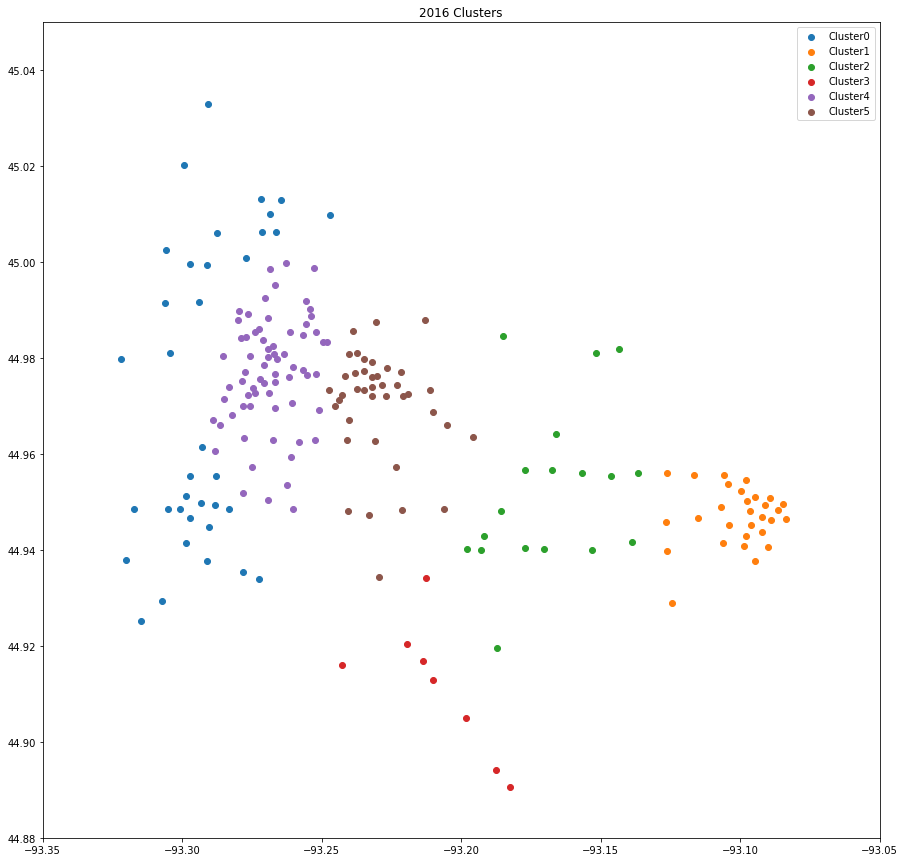

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=[15,15])
plt.xlim([-93.35,-93.05])
plt.ylim([44.88,45.05])

year = 2016

for k in range(0,6):
    temp = nr_station.loc[year, :][nr_station.loc[year, 'Cluster'] == k]
    ax = plt.scatter(temp.Longitude, temp.Latitude, label='Cluster'+str(k))
    
    ax = plt.gca()
    ax.set_title(str(year)+' Clusters')
    ax.legend()
    
plt.show()